In [2]:
import matplotlib.pyplot as plt
import math
import numpy as np
import scipy as sp
import qmcpy as qp
from scipy import stats
from copy import deepcopy
import sympy as sy
import sympy.stats
from scipy.stats import norm
figpath = '' #this path sends the figures to the directory that you want
savefigs = True
imgfrmt = 'pdf' #kind of format to save figures as

array([10.50997542, 11.04900927,  3.87332424])

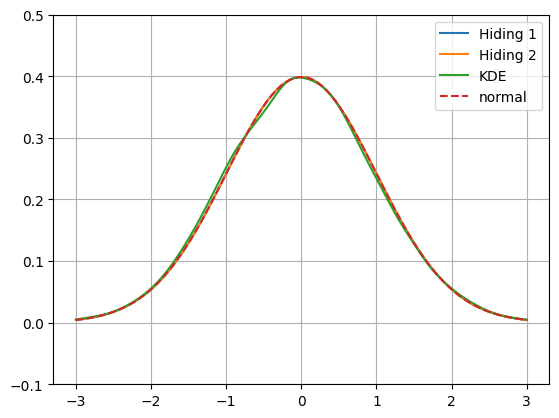

In [3]:
d = 1
n = 2**14

def condDensity1(x, y2):
    return norm.pdf((x - y2) / 0.6) / 0.6

def condDensity2(x, y1):
    return norm.pdf((x - y1) / 0.8) / 0.8

def condEstimator1(x, realizations):
    sum = 0
    n = len(realizations)
    for j in range(n):
        sum += condDensity1(x, realizations[j])
    return sum / n

def condEstimator2(x, realizations):
    sum = 0
    n = len(realizations)
    for j in range(n):
        sum += condDensity2(x, realizations[j])
    return sum / n

# averageAcross = 1
# def averagedCondEstimator1(x):
#     sum = 0.0
#     for i in range(averageAcross):
#         uniformPoints = qp.IIDStdUniform(d).gen_samples(n)
#         realizations2 = 0.8*norm.ppf(uniformPoints) + 0
#         sum += condEstimator1(x, realizations2) / averageAcross
#     return sum

# def averagedCondEstimator2(x):
#     sum = 0.0
#     for i in range(averageAcross):
#         uniformPoints = qp.IIDStdUniform(d).gen_samples(n)
#         realizations2 = 0.6*norm.ppf(uniformPoints) + 0
#         sum += condEstimator2(x, realizations2) / averageAcross
#     return sum

def kernelDensityEstimator(x, uniformPoints, bandwidth):
    n = len(uniformPoints)
    def gaussianKernel(z):
        return np.exp(-z**2) / math.sqrt(math.pi)
    sum = 0
    def thisFunc(z1, z2):
        return 0.6*norm.ppf(z1) + 0.8*norm.ppf(z2)
    for i in range(n):
        sum += (1 / (n * bandwidth)) * gaussianKernel((x - thisFunc(uniformPoints[i][0], uniformPoints[i][1])) / bandwidth)
    return sum
    
uniformPoints1d = qp.IIDStdUniform(d).gen_samples(n)
uniformPoints2d = qp.IIDStdUniform(2).gen_samples(n)
uniformRealization2 = 0.8*norm.ppf(uniformPoints1d) + 0
uniformRealization1 = 0.6*norm.ppf(uniformPoints1d) + 0

sobolPoints = qp.Sobol(d).gen_samples(n)
sobolRealization2 = 0.8*norm.ppf(sobolPoints) + 0
sobolRealization1 = 0.6*norm.ppf(sobolPoints) + 0


nEval = 100
evalPoints = np.linspace(-3, 3, nEval)
fig, ax = plt.subplots()


list1 = condEstimator1(evalPoints, sobolRealization2)
ax.plot(evalPoints, list1, label = 'Hiding 1')

list2 = condEstimator2(evalPoints, sobolRealization1)
ax.plot(evalPoints, list2, label = 'Hiding 2')


Q = 7.5671927
bandwidth = Q**(1/5) / n**(1/5)
list3 = kernelDensityEstimator(evalPoints, uniformPoints2d, bandwidth)
ax.plot(evalPoints, list3, label = 'KDE')

ax.plot(evalPoints, norm.pdf(evalPoints), '--', label = 'normal')
ax.set_ylim(-0.1, 0.5)
legend = ax.legend()

nMise = 100
misePoints = np.linspace(-3, 3, nMise)
estimatedMise1 = (6 / nMise) * np.sum((list1 - norm.pdf(misePoints))**2)
estimatedMise2 = (6 / nMise) * np.sum((list2 - norm.pdf(misePoints))**2)
estimatedMiseKDE = (6 / nMise) * np.sum((list3 - norm.pdf(misePoints))**2)
ax.grid(True)

-np.log10([estimatedMise1, estimatedMise2, estimatedMiseKDE])






In [4]:
def getError(pointSetType, n, method):
    nMise = 100
    misePoints = np.linspace(-3, 3, nMise)

    # nEval = 100
    # evalPoints = np.linspace(-3, 3, nEval)
    
    if n <= 0:
        raise Exception("Not valid choice of n")
    
    if method == "KDE":
        if pointSetType == "MC":
            pointSet = qp.IIDStdUniform(2).gen_samples(n)
        elif pointSetType == "Sobol":
            pointSet = qp.Sobol(2).gen_samples(n)
        else:
            raise Exception("Not support pointSetType")
        # VERY HACKY JOB OF HANDLING VARIABLE BANDIWDTHS DO NOT OPEN DO NOT OPEN USING OPTIMAL USING FORMULA
        Q = 7.5671927 #optimal bandwidth if the density is standard normal and kernel is gaussian
        bandwidth = Q**(1/5) / n**(1/5)
        evaluatedPoints = kernelDensityEstimator(misePoints, pointSet, bandwidth)
        estimatedMiseKDE = (6 / nMise) * np.sum((evaluatedPoints - norm.pdf(misePoints))**2)
        return estimatedMiseKDE
    
    elif method == "hiding1" or method == "hiding2":
        if pointSetType == "MC":
            pointSet = qp.IIDStdUniform(1).gen_samples(n)
        elif pointSetType == "Sobol":
            pointSet = qp.Sobol(1).gen_samples(n)
        else:
            raise Exception("Not supported pointSetType")
        
        if method == "hiding1":
            realization2 = 0.8*norm.ppf(pointSet)
            evaluatedPoints = condEstimator1(misePoints, realization2)
            estimatedMise1 = (6 / nMise) * np.sum((evaluatedPoints - norm.pdf(misePoints))**2)
            return estimatedMise1
        elif method == "hiding2":
            realization1 = 0.6*norm.ppf(pointSet)
            evaluatedPoints = condEstimator2(misePoints, realization1)
            estimatedMise2 = (6 / nMise) * np.sum((evaluatedPoints - norm.pdf(misePoints))**2)
            return estimatedMise2
    
    else:
        raise Exception("Not supported method")
    
    raise Exception("How did we get here?")
    
def getAveragedLog10Error(pointSetType, n, method, averageOver):
    if averageOver <= 0:
        raise Exception("Not valid averageOver")
    avg = 0
    for i in range(averageOver):
        avg += (1 / averageOver) * getError(pointSetType, n, method)
    return -np.log10(avg)

# for l in ["hiding1", "hiding2", "KDE"]:
#     for k in ["MC", "Sobol"]:
#         output = []
#         for j in range(10, 17, 2):
#             output.append(getAveragedLog10Error(k, 2**j, l, 8))
#         print(k, l, output)


for k in ["MC", "Sobol"]:
    output = []
    for j in range(10, 13, 2):
        output.append(getAveragedLog10Error(k, 2**j, "KDE", 8))
    print(k, output)


MC [3.033643657992711, 3.3864483615388337]
Sobol [3.6054889285285197, 4.0789415683718415]


In [6]:
def theFunc(x): #input a vector of length three, outputs the function applies to x from Y = f(X)
    return 8*x[0]*x[1]*x[2]


def truePDF(y): #input point to evaluate, output the conditional density
    output = [0] * len(y)
    for j in range(len(y)):
        if y[j] > 8 or y[j] < 0:
            output[j] = 0
        else:
            output[j] = (1/16) * (np.log(y[j] / 8))**2
    return output
         

def conditionalDensity1(y, x2, x3): #input points to evaluate and realization, output the conditional density
    test = y / (x2*x3)
    for j in range(len(test)):
        if test[j] > 1 or test[j] < 0:
            test[j]=0
    return test / y
    

def conditionalDensity2(y, x1, x3): #input points to evaluate and realization, output the conditional density
    test = y / (x1*x3)
    for j in range(len(test)):
        if test[j] > 2 or test[j] < 0:
            test[j] = 0
    return test / (2*y)


def conditionalDensity3(y, x1, x2): #intput points to evaluate and realization, #output the conditional density
    test = y / (x1*x2)
    for j in range(len(test)):
        if test[j] > 4 or test[j] < 0:
            test[j] = 0
    return test / (4*y)

def inverseCDF1(y): #expecting points in [0,1]
    return y

def inverseCDF2(y):
    return 2*y

def inverseCDF3(y):
    return 4*y

def kernelDensityEstimator(y, pointSet, bandwidth): #input point to evaluate, realiziations of U, and bandwidth; output the value of the KDE at y
    n = len(pointSet)
    def gaussianKernel(z):
         return np.exp(-z**2) / math.sqrt(math.pi)
    sum = 0
    for i in range(n):
        sum += (1 / (n*bandwidth)) * gaussianKernel((y - theFunc(pointSet[i])) / bandwidth)
    return sum

def conditionalEstimator(y, condDensity, realizations1, realizations2): #input point to evaluate, conditional density, and realizations; output the conditional estimator at the point
    if len(realizations1) != len(realizations2):
        raise Exception("realizations are of different size")
    else:
        outPut = 0
        n = len(realizations1)
        for j in range(n):
            outPut += condDensity(y, realizations1[j], realizations2[j]) / n
        return outPut


In [54]:

start, end = 0.01, 8
nError = 100


def getError2(pointSetType, n, method):

    errorPoints = np.linspace(start, end, nError) #the linspace changes

    if n <= 0:
        raise Exception("n must be a positive integer")
    if not (pointSetType == "MC" or pointSetType == "Sobol"):
        raise Exception("Currently supported pointSetTypes are IIDStdUniform and Sobol")
    
    if method == "KDE":
        if pointSetType == "MC":
            pointSet = qp.IIDStdUniform(3).gen_samples(n) #the dimension of the uniform points changes
        elif pointSetType == "Sobol":
            pointSet = qp.Sobol(3).gen_samples(n) #the dimension of the uniform points changes
        
        bandwidth = (0.00000565787743961 / n)**(1/5) #chosen arbitrarily, hard to automate
        evaluatedPoints = kernelDensityEstimator(errorPoints, pointSet, bandwidth)
    
    elif method == "hiding1" or method == "hiding2" or method == "hiding3": #this is super not scalable to other things, maybe dictionary
        if pointSetType == "MC":
            pointSet = qp.IIDStdUniform(2).gen_samples(n) #dimension is the total number of ways of hiding - 1
        elif pointSetType == "Sobol":
            pointSet = qp.Sobol(2).gen_samples(n) #dimension is the total number of ways of hiding - 1
        

        #method selecting schemes seems to be the most repetitive
        if method == "hiding1":
            realizations2 = 2*pointSet[:, 0] #this is the inverse cdf applied to the first entries
            realizations3 = 4*pointSet[:, 1] #this is the inverse cdf applied to the second entries
            evaluatedPoints = conditionalEstimator(errorPoints, conditionalDensity1, realizations2, realizations3)

        if method == "hiding2":
            realizations1 = pointSet[:, 0] #this is the inverse cdf applied to the first entries
            realizations3 = 4*pointSet[:, 1] #this is the inverse cdf applied to the second entries
            evaluatedPoints = conditionalEstimator(errorPoints, conditionalDensity2, realizations1, realizations3)

        if method == "hiding3":
            realizations1 = pointSet[:, 0] #this is the inverse cdf applied to the first entries
            realizations2 = 2*pointSet[:, 1] #this is the inverse cdf applied to the second entries
            evaluatedPoints = conditionalEstimator(errorPoints, conditionalDensity3, realizations1, realizations2)

    else:
        raise Exception("Unsupported method, try KDE or hiding#")

    estimatedError = (8 / nError) * np.sum((evaluatedPoints - truePDF(errorPoints))**2)
    return estimatedError



def getAveragedLog10Error(pointSetType, n, method, averageOver):
    if averageOver <= 0:
        raise Exception("averageOver must be a postive integer")
    avg = 0
    for i in range(averageOver):
        avg += (1 / averageOver) * getError2(pointSetType, n, method)
    return -np.log10(avg)


for method in ["hiding3"]:
    for points in ["Sobol"]:
        output = []
        for exp in [14]:
            output.append(getAveragedLog10Error(points, 2**exp, method, 8))
        print(points, method, output)




Sobol hiding3 [4.724288180711783]


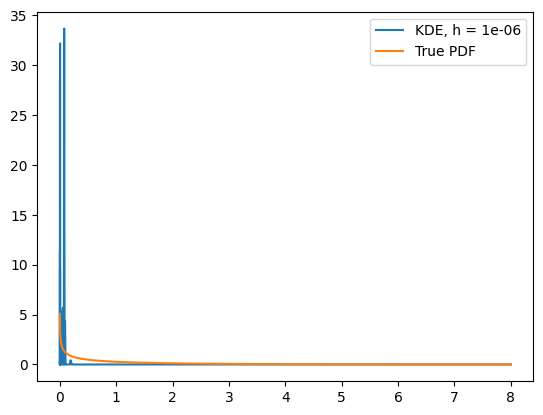

In [10]:
n = 2**14

nEval = 100
evalPoints = np.linspace(0.001, 8, nEval) #uniform
specialEvalPoints = np.logspace(-10, 3, num = nEval, base = 2) #log uniform
fig, ax = plt.subplots()

sobolPoints = qp.Sobol(2).gen_samples(n)

KDEMCPoints = qp.IIDStdUniform(3).gen_samples(n)

# list1 = conditionalEstimator(evalPoints, conditionalDensity1, 2*sobolPoints[:, 0], 4*sobolPoints[:, 0])
# ax.plot(evalPoints, list1, label = 'Hiding 1')

# list2 = conditionalEstimator(evalPoints, conditionalDensity2, 1*sobolPoints[:, 0], 4*sobolPoints[:, 0])
# ax.plot(evalPoints, list2, label = 'Hiding2')

# list3 = conditionalEstimator(evalPoints, conditionalDensity3, 1*sobolPoints[:, 0], 2*sobolPoints[:, 0])
# ax.plot(evalPoints, list3, label = 'Hiding3')

# Q = 59.8096896051
# bandwidth = Q**(1/5) / n**(1/5)
list4 = kernelDensityEstimator(specialEvalPoints, KDEMCPoints, 0.000001)
ax.plot(specialEvalPoints, list4, label = f'KDE, h = {0.000001}')

trueList = truePDF(specialEvalPoints)
ax.plot(specialEvalPoints, trueList, label = 'True PDF')

legend = ax.legend()


24.097382288616224


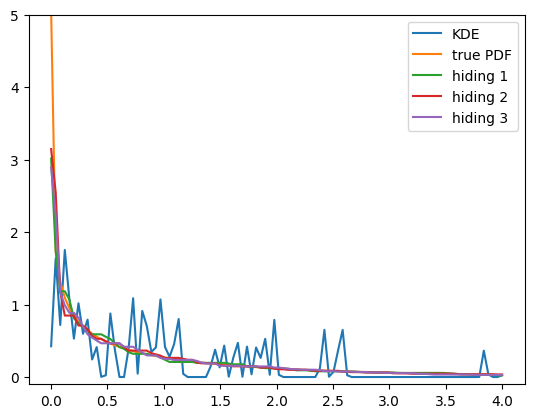

In [53]:
nEval = 100
evalPoints = np.linspace(0.001, 4, nEval) #uniform
specialEvalPoints = np.logspace(-10, 3, num = nEval, base = 2) #log uniform
fig, ax = plt.subplots()


for n in [6]:
    sobol1 = qp.Sobol(2).gen_samples(2**n)
    sobol2 = qp.Sobol(2).gen_samples(2**n)
    sobol3 = qp.Sobol(2).gen_samples(2**n)
    KDEMCPoints = qp.IIDStdUniform(3).gen_samples(2**n)
    evaluatedPoints = kernelDensityEstimator(evalPoints, KDEMCPoints, 0.02)
    plt.plot(evalPoints, evaluatedPoints, label = "KDE")
    plt.plot(evalPoints, truePDF(evalPoints), label = "true PDF")
    plt.plot(evalPoints, conditionalEstimator(evalPoints, conditionalDensity1, 2*sobol1[:, 0], 4*sobol1[:, 1]), label = "hiding 1")
    plt.plot(evalPoints, conditionalEstimator(evalPoints, conditionalDensity2, sobol2[:, 0], 4*sobol2[:, 1]), label = "hiding 2")
    plt.plot(evalPoints, conditionalEstimator(evalPoints, conditionalDensity3, sobol3[:, 0], 2*sobol3[:, 1]), label = "hiding 3")
    
print(np.sum(evaluatedPoints))

ax.set_ylim(-0.1, 5)
plt.legend()

In [51]:
def theFunc(x): #input a vector of length three, outputs the function applies to x from Y = f(X)
    return 8*x[0]*x[1]*x[2]


def truePDF(y): #input point to evaluate, output the conditional density
    output = [0] * len(y)
    for j in range(len(y)):
        if y[j] > 8 or y[j] < 0:
            output[j] = 0
        else:
            output[j] = (1/16) * (np.log(y[j] / 8))**2
    return output
         

def conditionalDensity1(y, x2, x3): #input points to evaluate and realization, output the conditional density
    test = y / (x2*x3)
    for j in range(len(test)):
        if test[j] > 1 or test[j] < 0:
            test[j]=0
    return test / y
    

def conditionalDensity2(y, x1, x3): #input points to evaluate and realization, output the conditional density
    test = y / (x1*x3)
    for j in range(len(test)):
        if test[j] > 2 or test[j] < 0:
            test[j] = 0
    return test / (2*y)


def conditionalDensity3(y, x1, x2): #intput points to evaluate and realization, #output the conditional density
    test = y / (x1*x2)
    for j in range(len(test)):
        if test[j] > 4 or test[j] < 0:
            test[j] = 0
    return test / (4*y)

def inverseCDF1(y): #expecting points in [0,1]
    return y

def inverseCDF2(y):
    return 2*y

def inverseCDF3(y):
    return 4*y

def kernelDensityEstimator(y, pointSet, bandwidth): #input point to evaluate, realiziations of U, and bandwidth; output the value of the KDE at y
    n = len(pointSet)
    def gaussianKernel(z):
         return np.exp(-z**2) / math.sqrt(math.pi)
    sum = 0
    for i in range(n):
        sum += (1 / (n*bandwidth)) * gaussianKernel((y - theFunc(pointSet[i])) / bandwidth)
    return sum

def conditionalEstimator(y, condDensity, realizations1, realizations2): #input point to evaluate, conditional density, and realizations; output the conditional estimator at the point
    if len(realizations1) != len(realizations2):
        raise Exception("realizations are of different size")
    else:
        outPut = 0
        n = len(realizations1)
        for j in range(n):
            outPut += condDensity(y, realizations1[j], realizations2[j]) / n
        return outPut



InverseCDFs = [inverseCDF1, inverseCDF2, inverseCDF3]
conditionalDensities = [conditionalDensity1, conditionalDensity2, conditionalDensity3]





def getErrorDimensionis3(pointSetType, n, method, conditionalDensities, start, end, truePDF, InverseCDFs, theFunction, hiding):
    # pointSetType specifies MC or Sobol'
    # n specifies the number of realizations
    # methods is a (something) of conditionalDensities
    # start, end specify over what inverval we are working
    # truePDF is the truePDF of the random variable (not sure what tot do when this is not available)
    # InverseCDFs is a (something) of InverseCDFs that transform uniform points to the appropriate distribution
    # dimension gives the number of random variables that Y depends on (equivalently the length of the uniform vector)
    # theFunction is the f from Y = f(X_1, ..., X_{dimension})

    #arbitrarily setting the dimension to 3 just for learning purposes
    
    
    nError = 100
    errorPoints = np.linspace(start, end, nError) #the linspace changes


    def KDE(y, pointSet, bandwidth):
        n = len(pointSet)
        def gaussianKernel(z):
            return np.exp(-z**2) / math.sqrt(math.pi)
        sum = 0
        for i in range(n):
            sum += (1 / (n*bandwidth)) * gaussianKernel((y - theFunction(pointSet[i])) / bandwidth)
        return sum

        

    if n <= 0:
        raise Exception("n must be a positive integer")
    
    if pointSetType == "MC":
        pointSet = qp.IIDStdUniform(3).gen_samples(n) #the dimension of the uniform points changes
    elif pointSetType == "Sobol":
        pointSet = qp.IIDStdUniform(3).gen_samples(n) #the dimension of the uniform points changes
    else:
        Exception("Currently supported pointSetTypes are MC and Sobol")

    
    if method == "KDE":
        Q = 5 #I AM NOT SURE WHAT IS GOING ON HERE
        bandwidth = (Q / n)**(1/5) 
        evaluatedPoints = kernelDensityEstimator(errorPoints, pointSet, bandwidth)
    elif method == "conditional":
        realizations1 = InverseCDFs[0](pointSet[:, 0])
        realizations2 = InverseCDFs[1](pointSet[:, 1])
        realizations3 = InverseCDFs[2](pointSet[:, 2])
        if hiding == "hiding1":
            evaluatedPoints = conditionalEstimator(errorPoints, conditionalDensity1, realizations2, realizations3)

        if hiding == "hiding2":
            evaluatedPoints = conditionalEstimator(errorPoints, conditionalDensity2, realizations1, realizations3)

        if hiding == "hiding3":
            evaluatedPoints = conditionalEstimator(errorPoints, conditionalDensity3, realizations1, realizations2)
    else:
        raise Exception("Unsupported method, try KDE or conditional")


    estimatedError = ((end - start) / nMise) * np.sum((evaluatedPoints - truePDF(errorPoints))**2)
    return -np.log10(estimatedError)


getErrorDimensionis3(pointSetType = "Sobol", n = 2**14, method = "conditional", start = 0.01, 
                     end = 8, truePDF = truePDF, InverseCDFs = InverseCDFs, theFunction = theFunc,
                     conditionalDensities = conditionalDensities, hiding = "hiding1")


        



4.06947413067969